# Lab 8

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.datasets as dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
import pickle

## Problem 1

### Part 1

In [ ]:
data_test= dataset.MNIST(root='./data', train=False, download=True,transform = None)
data_train = dataset.MNIST(root='./data', train=True, download=True,transform = None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
Y = data_train.targets.numpy()
X = data_train.data.numpy() 

In [ ]:
mean_train = data_train.data.float().mean() / 255
std_train = data_train.data.float().std() / 255
mean_test = data_test.data.float().mean() / 255
std_test = data_test.data.float().std() / 255

In [ ]:
mean_train,std_train,mean_test,mean_test

(tensor(0.1307), tensor(0.3081), tensor(0.1325), tensor(0.1325))

In [ ]:
X_train,X_val,Y_train,Y_val = tts(X,Y,test_size = 0.2)
X_train.shape

(48000, 28, 28)

In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(5),transforms.RandomCrop(28, padding=2),transforms.ToTensor(),transforms.Normalize(mean=[mean_train], std=[std_train])])

test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[mean_test], std=[std_test])])

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

In [ ]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [48000, 12000])

### Part 2

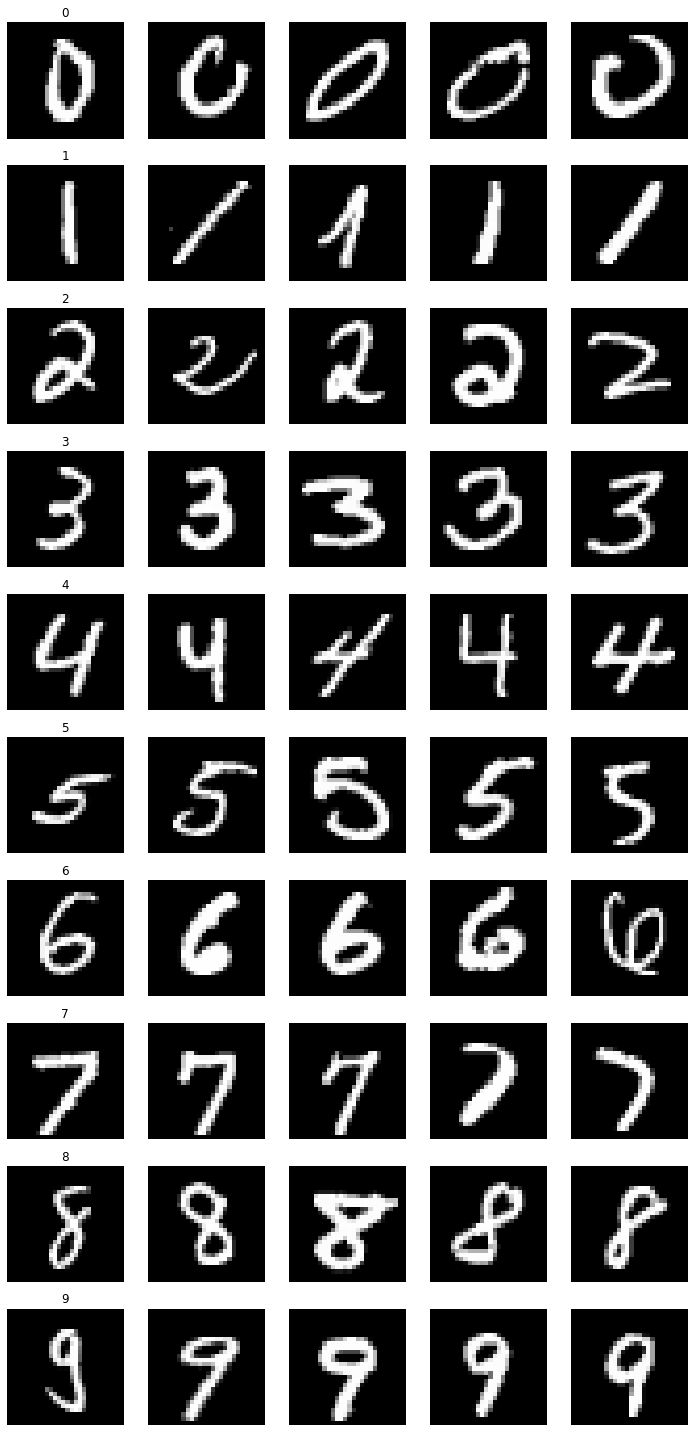

In [ ]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fig, axs = plt.subplots(10, 5, figsize=(10, 20))
for i in range(10):
    class_samples = np.random.choice(np.where(train_dataset.dataset.targets == i)[0], size=5, replace=False)
    for j, sample_idx in enumerate(class_samples):
        axs[i, j].imshow(train_dataset.dataset.data[sample_idx], cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(class_names[i])
plt.tight_layout()
plt.show()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

### Part 3

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MLP(784,256,10)

print(f'The number of trainable parameters is {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

The number of trainable parameters is 269,322


### Part 4

In [ ]:
def run_epochs(num_epochs,criterion,optimizer,model):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  for epoch in range(num_epochs):   ## Running for 5 epochs
      
      model.train()
      train_loss = 0.0
      train_correct = 0
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

          train_loss += loss.item() * inputs.size(0)
          train_correct += torch.sum(torch.argmax(outputs, dim=1) == targets)

      train_loss /= len(train_loader.dataset)
      train_acc = train_correct / len(train_loader.dataset)
      train_losses.append(train_loss)
      train_accs.append(train_acc)

      model.eval()
      val_loss = 0.0
      val_correct = 0
      with torch.no_grad():
          for inputs, targets in val_loader:
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              val_loss += loss.item() * inputs.size(0)
              val_correct += torch.sum(torch.argmax(outputs, dim=1) == targets)

      val_loss /= len(val_loader.dataset)
      val_acc = val_correct / len(val_loader.dataset)
      val_losses.append(val_loss)
      val_accs.append(val_acc)


      if val_acc > best_acc:
          best_acc = val_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, '
            f'Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


  model.load_state_dict(best_model_wts)
  print('Best Val Acc: {:.4f}'.format(best_acc))
  return train_losses,train_accs,val_losses,val_accs

num_epochs = 5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses,train_accs,val_losses,val_accs  = run_epochs(num_epochs,criterion,optimizer,model)

Epoch 1/5, Train Loss: 0.0730, Train Acc: 0.9772, Val Loss: 0.0809, Val Acc: 0.9758
Epoch 2/5, Train Loss: 0.0734, Train Acc: 0.9768, Val Loss: 0.0806, Val Acc: 0.9766
Epoch 3/5, Train Loss: 0.0704, Train Acc: 0.9779, Val Loss: 0.0996, Val Acc: 0.9688
Epoch 4/5, Train Loss: 0.0662, Train Acc: 0.9791, Val Loss: 0.0816, Val Acc: 0.9761
Epoch 5/5, Train Loss: 0.0648, Train Acc: 0.9797, Val Loss: 0.0688, Val Acc: 0.9793
Best Val Acc: 0.9793


### Part 5


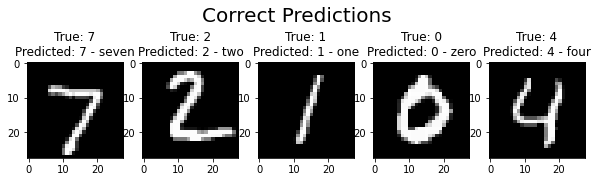

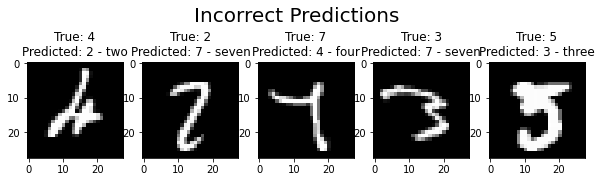

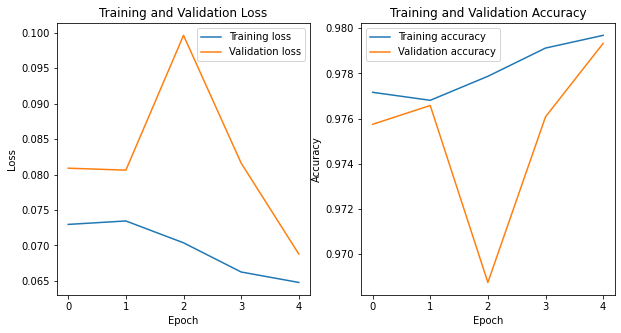

In [ ]:
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

correct_indices = []
incorrect_indices = []
for i in range(len(test_dataset)):
    if test_preds[i] == test_targets[i]:
        if len(correct_indices) < 5:
            correct_indices.append(i)
    else:
        if len(incorrect_indices) < 5:
            incorrect_indices.append(i)
    if len(correct_indices) == 5 and len(incorrect_indices) == 5:
        break


fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for i, idx in enumerate(correct_indices):
    img, true_label = test_dataset[idx]
    pred_label = test_dataset.classes[test_preds[idx]]
    axs[i].imshow(img.squeeze().numpy(), cmap='gray')
    axs[i].set(title=f"True: {true_label}\nPredicted: {pred_label}")
plt.suptitle("Correct Predictions", fontsize=20)
plt.show()


fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for i, idx in enumerate(incorrect_indices):
    img, true_label = test_dataset[idx]
    pred_label = test_dataset.classes[test_preds[idx]]
    axs[i].imshow(img.squeeze().numpy(), cmap='gray')
    axs[i].set(title=f"True: {true_label}\nPredicted: {pred_label}")
plt.suptitle("Incorrect Predictions", fontsize=20)
plt.show()


plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,2,1),
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2),
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Problem 2

### Part 1

In [2]:
names = ["Sex",	"Length",	"Diameter",	"Height","Whole weight","Shucked weight","Viscera weight","Shell weight",	"Rings"]
abalone_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data",names = names)
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [3]:
abalone_df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [4]:
abalone_df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
for i in range(len(abalone_df["Height"])):
  if(abalone_df["Height"][i]==0):
    print(i)

1257
3996


In [6]:
X = abalone_df.copy()
X["Sex"] = LabelEncoder().fit_transform(X["Sex"])
X_scale = StandardScaler().fit_transform(X.drop(["Sex","Rings"],axis = 1))
X_scale = pd.DataFrame(data = X_scale,columns = names[1:-1])
X_scale["Sex"] = X["Sex"]
X_scale["Rings"] = X["Rings"]
X_scale = X_scale[names]
X_scale

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,2,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,15
1,2,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,7
2,0,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,9
3,2,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,10
4,1,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,7
...,...,...,...,...,...,...,...,...,...
4172,0,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062,11
4173,2,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685,10
4174,2,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955,9
4175,0,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739,10


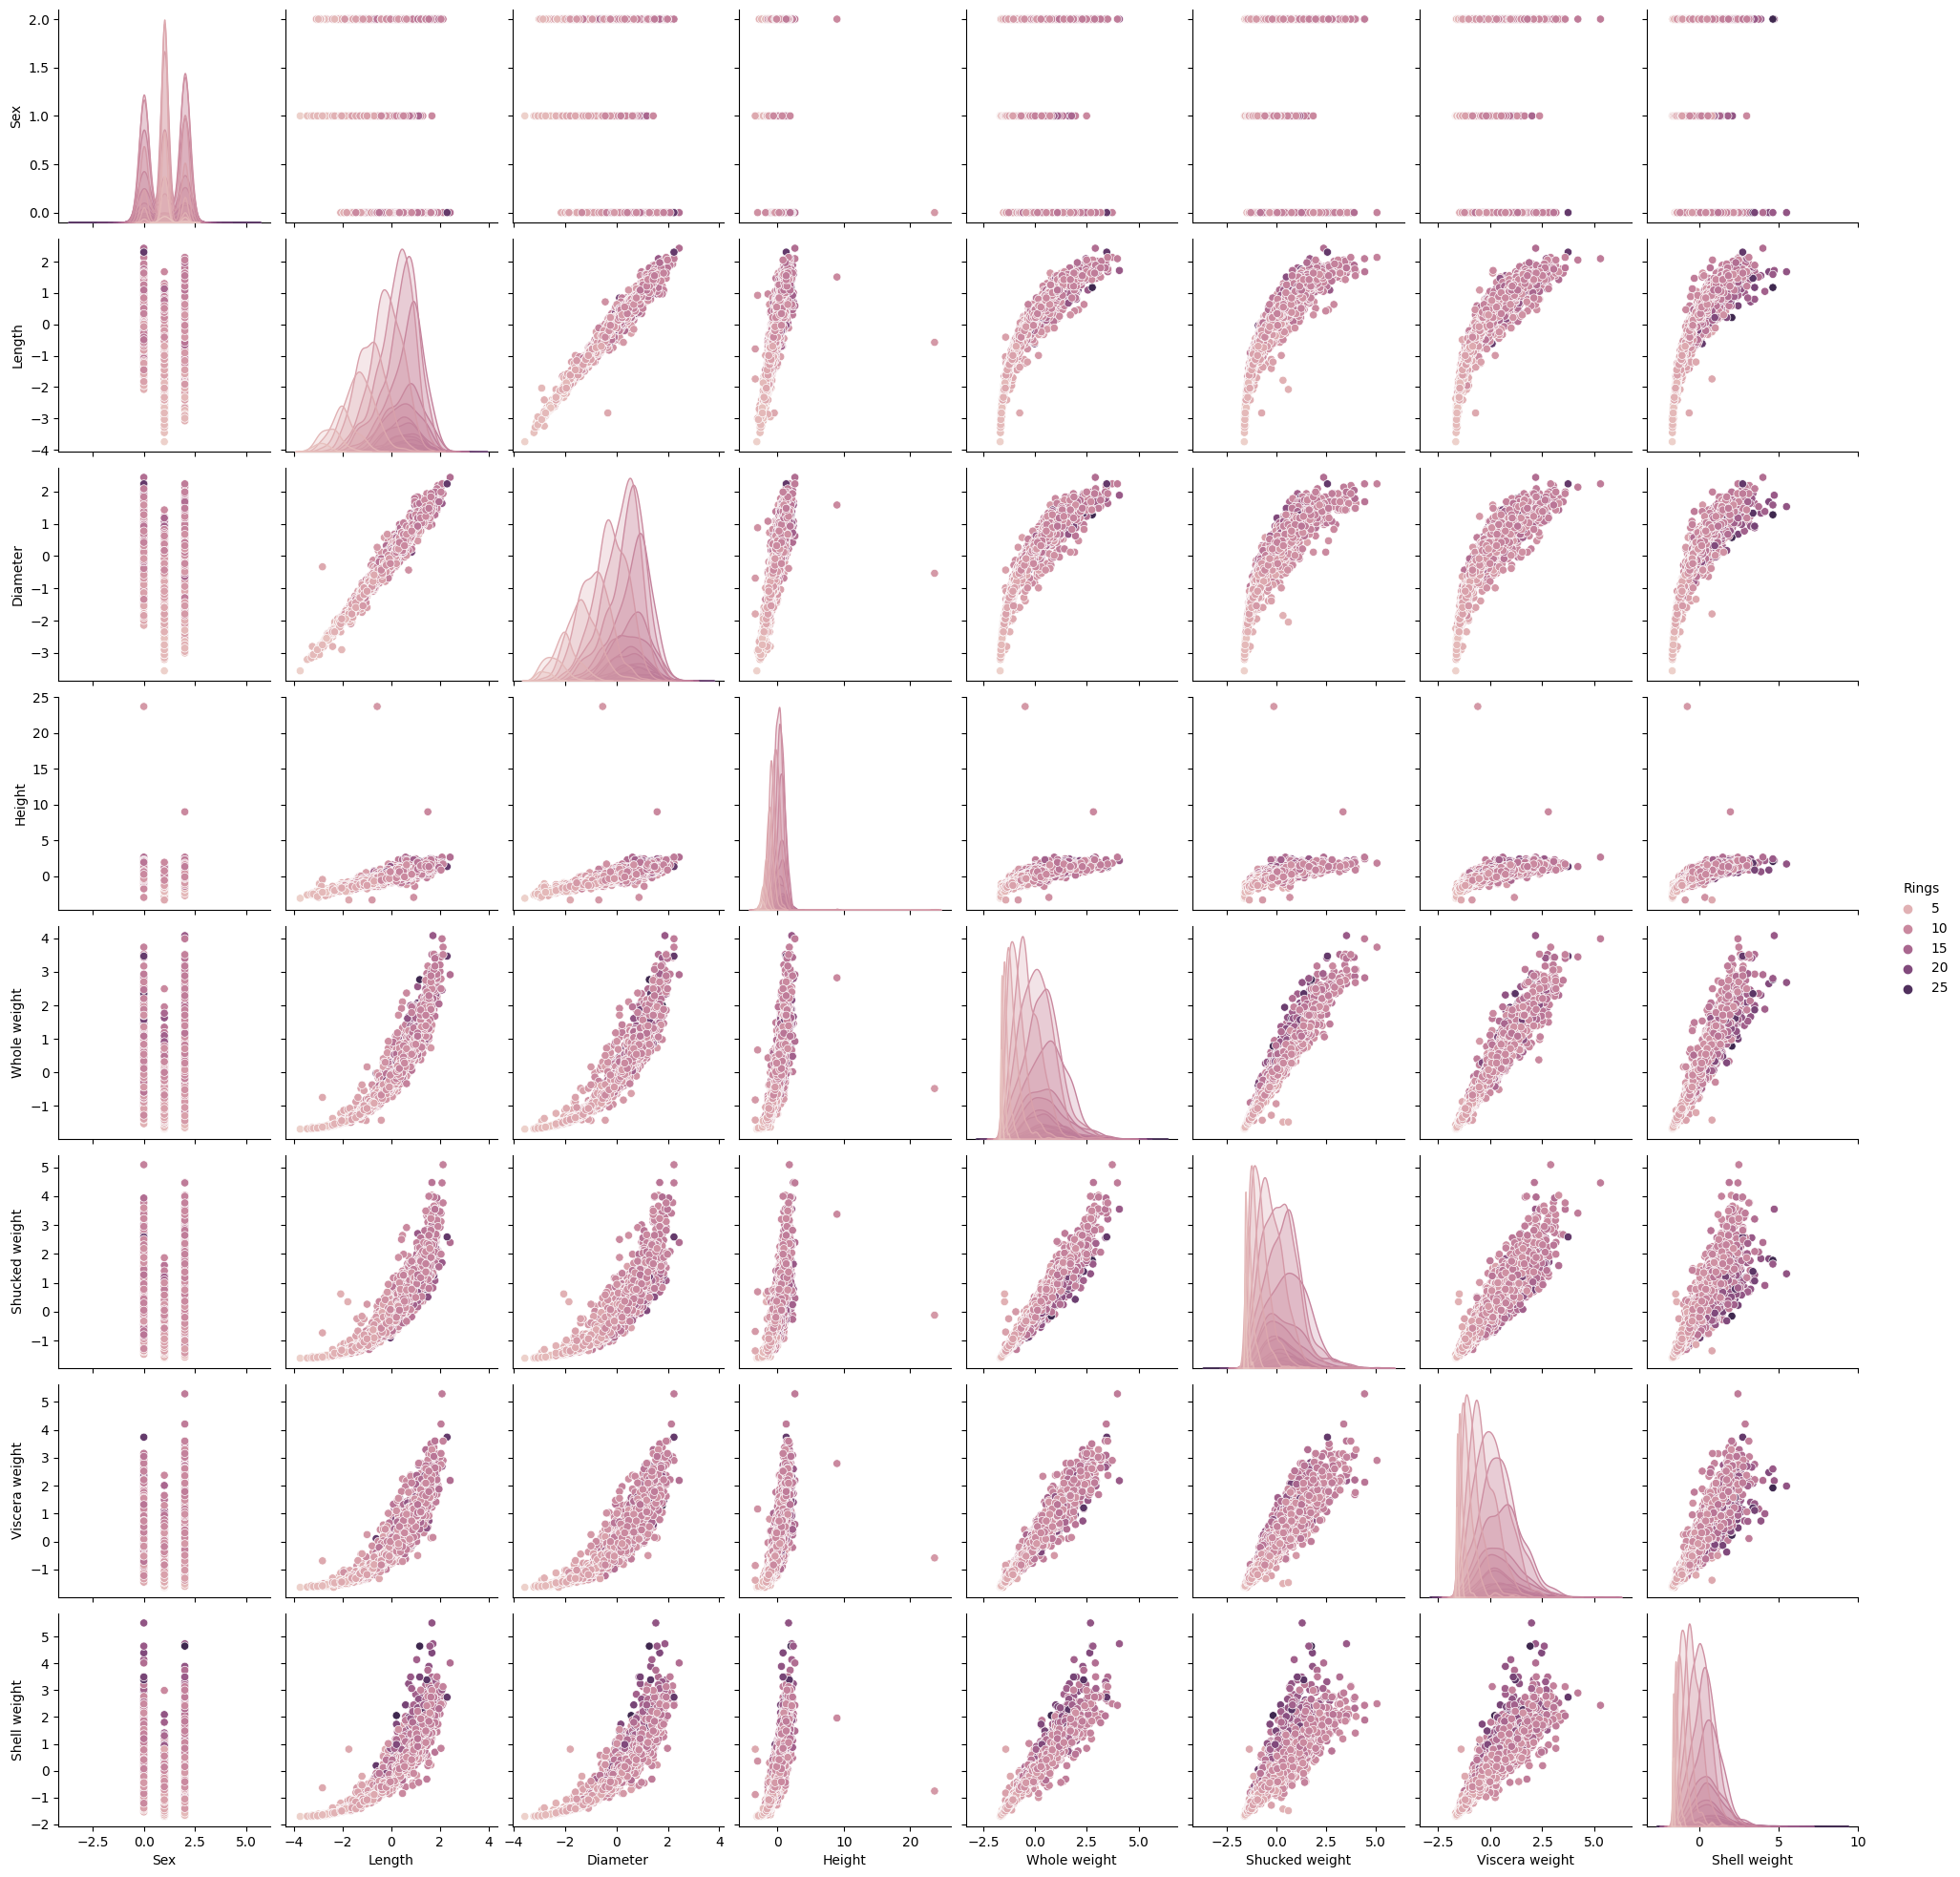

In [ ]:
sns.pairplot(data = X_scale,hue = "Rings")

In [7]:
class_no=[]
for n_rings in X_scale['Rings']:
    if(n_rings<8):
        class_no.append(0)
    elif(n_rings<13):
        class_no.append(1)
    elif(n_rings<18):
        class_no.append(2)
    else:
        class_no.append(3)

X_scale['Rings']=class_no
def stratify_split(X, Y, test_size=0.2, random_state=None):
    classes = np.unique(Y)
    train_indices, test_indices = [], []
    for c in classes:
        class_indices = np.where(Y == c)[0]
        n_class = len(class_indices)
        if n_class == 1:
            # Handle classes with only one example by including it in both sets
            train_indices.append(class_indices[0])
            test_indices.append(class_indices[0])
        else:
            n_test = int(np.ceil(n_class * test_size))
            n_train = n_class - n_test
            if random_state:
                np.random.seed(random_state)
            np.random.shuffle(class_indices)
            train_indices.extend(class_indices[:n_train])
            test_indices.extend(class_indices[n_train:])
    return X[train_indices], Y[train_indices], X[test_indices], Y[test_indices]

X_train,Y_train,X_test,Y_test = stratify_split(X_scale.drop("Rings",axis= 1).to_numpy(),X_scale["Rings"].to_numpy())

### Part 2

In [8]:
class MulticlassPerceptron:
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output, learning_rate=0.01,af = 'sigmoid',wt = 'random'):
        self.n_input = n_input
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
        self.learning_rate = learning_rate
        self.af = af
        # Initialize weights with random values

        
        self.W1 = np.random.randn(self.n_input, self.n_hidden1)-0.5
        self.b1 = np.zeros((1, self.n_hidden1))
        self.W2 = np.random.randn(self.n_hidden1, self.n_hidden2)-0.5
        self.b2 = np.zeros((1, self.n_hidden2))
        self.W3 = np.random.randn(self.n_hidden2, self.n_output)-0.5
        self.b3 = np.zeros((1, self.n_output))

        if(wt == 'zero'):
          self.w1 = np.zeros((self.n_input, self.n_hidden1)) 
          self.w2 = np.zeros((self.n_hidden1, self.n_hidden2))
          self.w3 = np.zeros((self.n_hidden2, self.n_output))
        if(wt == 'constant'):
          self.w1 = np.full((self.n_input, self.n_hidden1),0.1) 
          self.w2 = np.full((self.n_hidden1, self.n_hidden2),0.1)
          self.w3 = np.full((self.n_hidden2, self.n_output),0.1)
    
    def afunc(self,Z):
      if(self.af == 'sigmoid'):
        return  (1 / (1 + np.exp(-Z)))
      elif(self.af == 'relu'):
        return np.maximum(0, Z)
      else:
        return np.tanh(Z)
    def adfunc(self,Z):
      if(self.af == 'sigmoid'):
        sigmoid_x = 1 / (1 + np.exp(-Z))
        return sigmoid_x * (1 - sigmoid_x)

      if(self.af == 'relu'):
        return (Z > 0).astype(int)

      if(self.af == "tanh"):
        return 1 - np.tanh(Z)**2
    
    def softmax(self, x):
      exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
      return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        # Input layer to hidden layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.afunc(self.z1)
        
        # Hidden layer 1 to hidden layer 2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.afunc(self.z2)
        
        # Hidden layer 2 to output layer
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.y_hat = self.softmax(self.z3)
        
        return self.y_hat
    def backward_propagation(self, X, y, y_hat):
        # Output layer to hidden layer 2
        delta3 = y_hat
        y_adjusted = y - 1  # Adjust labels to start from 0
        delta3[range(X.shape[0]), y_adjusted] -= 1
        dW3 = np.dot(self.a2.T, delta3)
        db3 = np.sum(delta3, axis=0, keepdims=True)
        
        # Hidden layer 2 to hidden layer 1
        delta2 = np.dot(delta3, self.W3.T) * self.adfunc(self.z2)
        dW2 = np.dot(self.a1.T, delta2)
        db2 = np.sum(delta2, axis=0)
        
        # Hidden layer 1 to input layer
        delta1 = np.dot(delta2, self.W2.T) * self.adfunc(self.z1)
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)
        
        # Update weights and biases
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    def predict(self, X):
        y_hat = self.forward_propagation(X)
        return np.argmax(y_hat, axis=1)
    
    # stochastic gradient descent
    def fit(self, X_train, y_train, n_epochs=100, batch_size=32):
        for epoch in range(n_epochs):
            # Shuffle training data
            idx = np.random.permutation(X_train.shape[0])
            X_train = X_train[idx]
            y_train = y_train[idx]
            
            # Mini-batch training
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                # Forward propagation
                y_hat = self.forward_propagation(X_batch)
                
                # Backward propagation
                self.backward_propagation(X_batch, y_batch, y_hat)
    def save_weights(self, file_path):
      weights = {
          'W1': self.W1,
          'b1': self.b1,
          'W2': self.W2,
          'b2': self.b2,
          'W3': self.W3,
          'b3': self.b3
      }
      with open(file_path, 'wb') as f:
          pickle.dump(weights, f)
      print(f'Saved weights to {file_path}')

    def load_weights(self, file_path):
      with open(file_path, 'rb') as f:
          weights = pickle.load(f)
      self.W1 = weights['W1']
      self.b1 = weights['b1']
      self.W2 = weights['W2']
      self.b2 = weights['b2']
      self.W3 = weights['W3']
      self.b3 = weights['b3']
      print(f'Loaded weights from {file_path}')
            

In [13]:
cnt = 0
arr1 = []
pp = MulticlassPerceptron(8,16,8,4,0.01,"tanh")
pp.fit(X_train,Y_train,100,100)
output = pp.predict(X_test)
for i in range(len(Y_test)):
    if(output[i]+1 == Y_test[i]):
      cnt += 1
print(cnt/len(Y_test))

0.5937873357228196


### Part 3

In [22]:
arr1 = []
arr2 = []
arr3 = []
for i in range(100,501,100):
  cnt = 0
  pp = MulticlassPerceptron(8,16,8,4,0.01,"sigmoid")
  pp.fit(X_train,Y_train,i,100)
  output = pp.predict(X_test)
  for i in range(len(Y_test)):
      if(output[i]+1 == Y_test[i]):
        cnt += 1
  arr1.append(cnt/len(Y_test))
for i in range(100,501,100):
  cnt = 0
  pp = MulticlassPerceptron(8,16,8,4,0.01,"relu")
  pp.fit(X_train,Y_train,i,100)
  output = pp.predict(X_test)
  for i in range(len(Y_test)):
      if(output[i]+1 == Y_test[i]):
        cnt += 1
  arr2.append(cnt/len(Y_test))
for i in range(100,501,100):
  cnt = 0
  pp = MulticlassPerceptron(8,16,8,4,0.01,"tanh")
  pp.fit(X_train,Y_train,i,100)
  output = pp.predict(X_test)
  for i in range(len(Y_test)):
      if(output[i]+1 == Y_test[i]):
        cnt += 1
  arr3.append(cnt/len(Y_test))

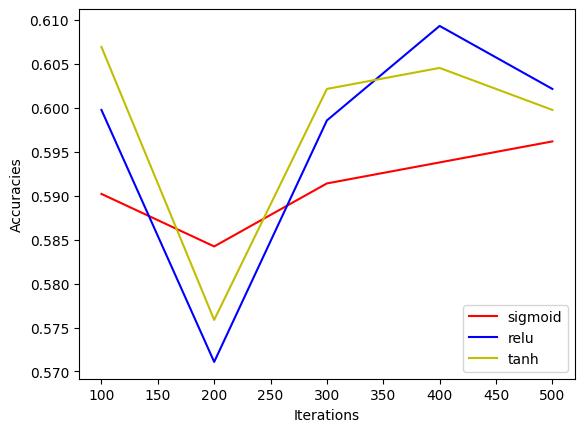

In [15]:
plt.plot(range(100,501,100),arr1,color = 'r',label = 'sigmoid')
plt.plot(range(100,501,100),arr2,color = 'b',label = 'relu')
plt.plot(range(100,501,100),arr3,color = 'y',label = 'tanh')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracies")
plt.show()

### Part 4

In [23]:
arr1 = []
arr2 = []
arr3 = []
for i in range(100,501,100):
  cnt = 0
  pp = MulticlassPerceptron(8,16,8,4,0.01,"sigmoid",'random')
  pp.fit(X_train,Y_train,i,100)
  output = pp.predict(X_test)
  for i in range(len(Y_test)):
      if(output[i]+1 == Y_test[i]):
        cnt += 1
  arr1.append(cnt/len(Y_test))
for i in range(100,501,100):
  cnt = 0
  pp = MulticlassPerceptron(8,16,8,4,0.01,"sigmoid",'zero')
  pp.fit(X_train,Y_train,i,100)
  output = pp.predict(X_test)
  for i in range(len(Y_test)):
      if(output[i]+1 == Y_test[i]):
        cnt += 1
  arr2.append(cnt/len(Y_test))
for i in range(100,501,100):
  cnt = 0
  pp = MulticlassPerceptron(8,16,8,4,0.01,"sigmoid",'constant')
  pp.fit(X_train,Y_train,i,100)
  output = pp.predict(X_test)
  for i in range(len(Y_test)):
      if(output[i]+1 == Y_test[i]):
        cnt += 1
  arr3.append(cnt/len(Y_test))

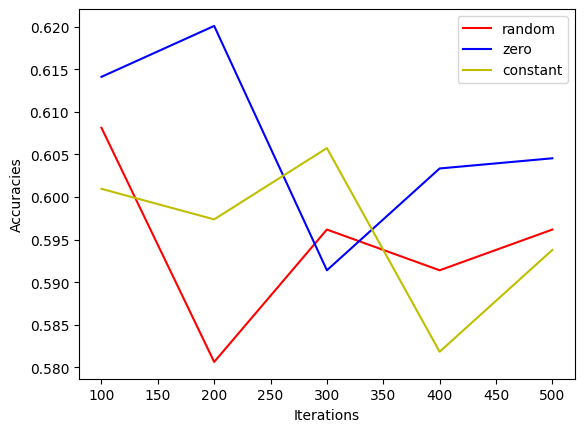

In [24]:
plt.plot(range(100,501,100),arr1,color = 'r',label = 'random')
plt.plot(range(100,501,100),arr2,color = 'b',label = 'zero')
plt.plot(range(100,501,100),arr3,color = 'y',label = 'constant')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracies")
plt.show()

### Part 5

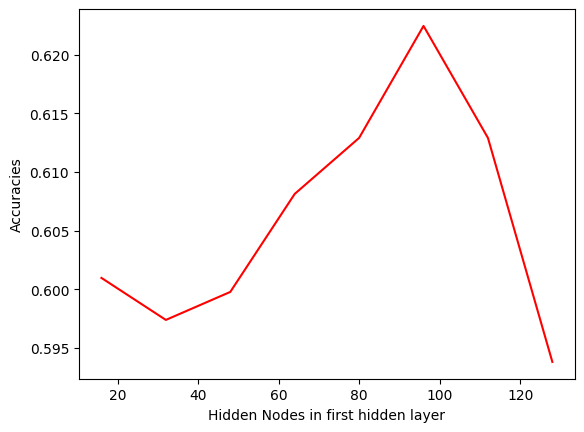

In [26]:
arr1 =[]
for i in range(16,129,16):
  pp = MulticlassPerceptron(8,i,i//2,4,0.01,"sigmoid",'random')
  pp.fit(X_train,Y_train,100,100)
  output = pp.predict(X_test)
  cnt = 0
  for i in range(len(Y_test)):
    if(output[i]+1 == Y_test[i]):
      cnt += 1
  arr1.append(cnt/len(Y_test))
plt.plot(range(16,129,16),arr1,color = 'r')
plt.xlabel("Hidden Nodes in first hidden layer")
plt.ylabel("Accuracies")
plt.show()

In [28]:
pp = MulticlassPerceptron(8,16,8,4,0.01,"sigmoid",'random')
pp.fit(X_train,Y_train,100,100)
output = pp.predict(X_test)
cnt = 0
for i in range(len(Y_test)):
  if(output[i]+1 == Y_test[i]):
    cnt += 1
arr1.append(cnt/len(Y_test))
pp.save_weights('model_weights.pkl')
pp.load_weights('model_weights.pkl')
with open('model_weights.pkl', 'rb') as f:
    weights = pickle.load(f)
print(weights)

Saved weights to model_weights.pkl
Loaded weights from model_weights.pkl
{'W1': array([[ 0.55227862,  0.92149921,  0.95230704,  0.94759358,  0.33458283,
        -0.35591803, -1.06434963, -1.26690635, -0.60966453, -1.32531236,
        -0.45933882,  0.86959531,  0.0246819 ,  1.4836678 , -3.96903104,
        -1.66408405],
       [ 1.50538093, -0.09880314, -0.14504745, -0.26151027, -1.15328189,
        -0.29452562,  0.17974943, -1.3455417 , -2.25764273, -1.57309222,
        -0.40251765,  0.43742881, -0.40064793, -1.59660764, -2.59147792,
         1.09226199],
       [-1.4665186 , -1.63541499,  0.75240432,  0.08136198, -1.103523  ,
         1.49194228, -2.0199257 , -0.58587386, -1.04641994, -0.62218631,
        -0.396757  , -1.8230149 , -1.13332091, -0.30574979, -0.45445813,
         0.80750779],
       [-0.73313321, -0.82278851, -0.49151671,  0.29525328, -0.09510652,
         2.0453273 , -0.51392945, -1.24186965, -0.91517721, -1.03319746,
         0.82408893, -2.18311721, -2.0660259 , -0.0